<a href="https://colab.research.google.com/github/nroselnik/Turtle_detection_speed-calculation/blob/main/Turtledetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

loading Roboflow workspace...
loading Roboflow project...


Saving idTrack - Made with Clipchamp.mp4 to idTrack - Made with Clipchamp (7).mp4
Average movement per frame: 79.03 pixels


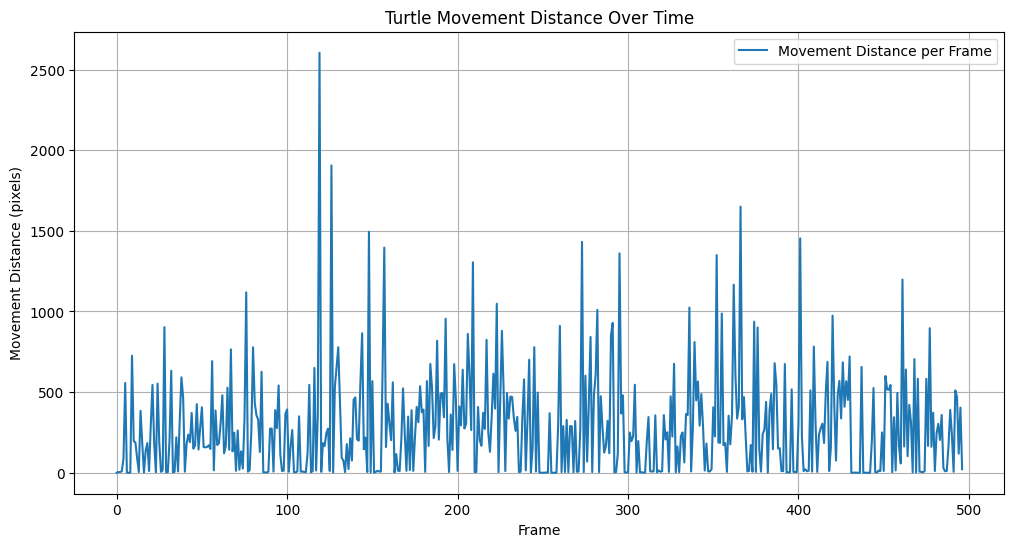

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Install required libraries
!pip install roboflow supervision opencv-python-headless matplotlib

# Import necessary libraries
from roboflow import Roboflow
import supervision as sv
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Initialize Roboflow and model
rf = Roboflow(api_key="Your own key")  # Replace with your secure API key
project = rf.workspace().project("turtle-hatchlings-detection")
model = project.version(1).model

# Upload video file or use Google Drive
from google.colab import files
uploaded = files.upload()  # Upload your video file here
video_path = list(uploaded.keys())[0]  # Get the uploaded file path

# Open video file
cap = cv2.VideoCapture(video_path)

# Define the codec and create VideoWriter object to save the output
output_path = "annotated_video.mp4"  # Output video file path
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for output video
fps = int(cap.get(cv2.CAP_PROP_FPS))  # Original video FPS
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# Annotators
label_annotator = sv.LabelAnnotator()
box_annotator = sv.BoxAnnotator()

# To store movement data
total_movement = 0
movement_count = 0
prev_positions = []
movement_distances = []  # To track movement distances per frame

# Process video frame by frame
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break  # Break loop if no frame is read (end of video)

    # Save the current frame as a temporary image file
    temp_image_path = "temp_frame.jpg"
    cv2.imwrite(temp_image_path, frame)

    # Run model prediction on the current frame
    result = model.predict(temp_image_path, confidence=40, overlap=30).json()

    # Parse the detections manually from Roboflow result
    boxes = []
    labels = []
    current_positions = []

    for pred in result['predictions']:
        # Calculate the coordinates for the bounding box
        x_center = pred['x']
        y_center = pred['y']
        width = pred['width']
        height = pred['height']
        x_min = x_center - width / 2
        y_min = y_center - height / 2
        x_max = x_center + width / 2
        y_max = y_center + height / 2

        # Add the bounding box and label
        boxes.append([x_min, y_min, x_max, y_max])
        labels.append(pred['class'])

        # Store the center positions
        current_positions.append((x_center, y_center))

    # Calculate movement by comparing with previous frame positions
    frame_movement = 0  # Movement for this frame
    if prev_positions and current_positions:
        for prev_pos in prev_positions:
            # Find the closest current position to the previous one
            min_distance = float('inf')
            for cur_pos in current_positions:
                distance = np.sqrt((cur_pos[0] - prev_pos[0]) ** 2 + (cur_pos[1] - prev_pos[1]) ** 2)
                if distance < min_distance and distance > 0:
                    min_distance = distance

            # Only accumulate movement if it's finite and reasonable
            if min_distance != float('inf'):
                frame_movement += min_distance
                total_movement += min_distance
                movement_count += 1

    # Update previous positions
    prev_positions = current_positions

    # Store frame movement distance
    movement_distances.append(frame_movement)

    # Create a Detections object for annotations only if there are boxes
    if boxes:
        detections = sv.Detections(
            xyxy=np.array(boxes),  # Bounding boxes in [x_min, y_min, x_max, y_max] format
            confidence=np.ones(len(boxes)),  # Dummy confidence scores
            class_id=np.zeros(len(boxes), dtype=int)  # Dummy class IDs
        )

        # Annotate the frame with bounding boxes and labels
        annotated_frame = box_annotator.annotate(scene=frame, detections=detections)
        annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)
    else:
        annotated_frame = frame  # If no detections, use the original frame

    # Write the annotated frame to the output video
    out.write(annotated_frame)

# Calculate average movement only if movement_count is not zero
average_movement = total_movement / movement_count if movement_count > 0 else 0
print(f"Average movement per frame: {average_movement:.2f} pixels")

# Release resources
cap.release()
out.release()

# Plot the movement distances
plt.figure(figsize=(12, 6))
plt.plot(movement_distances, label='Movement Distance per Frame')
plt.xlabel('Frame')
plt.ylabel('Movement Distance (pixels)')
plt.title('Turtle Movement Distance Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Download the annotated video
files.download(output_path)
